In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import pathlib
import seaborn as sns

In [11]:
# Define input directory
input_folder =  pathlib.Path("split_data/")

In [12]:
image_gen_train = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.08,
    zoom_range=0.07,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255,
    brightness_range=[0.3, 0.6],
    width_shift_range=0.07,
    height_shift_range=0.07
)

image_gen = ImageDataGenerator(
    rescale = 1/255,
)

In [23]:
batch_size = 32

training_data = image_gen_train.flow_from_directory(
    input_folder / 'train',
    class_mode = "binary",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 42
)

validation_data = image_gen.flow_from_directory(
    input_folder / 'val',
    class_mode = "binary",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 42
)

test_data = image_gen.flow_from_directory(
    input_folder / 'test',
    class_mode = "binary",
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False,
    seed = 42
)

Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.


In [27]:
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape, dtype=tf.float32, name="malaria_cells")

# Convolutional layers
X = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

# Flattening
X = Flatten()(X)

# Fully connected layers
X = Dense(units=64, activation='relu')(X)
output_tensor = Dense(units=1, activation='sigmoid', name="cell_classes")(X)

# Create model
model = Model(inputs=input_tensor, outputs=output_tensor)


In [28]:
model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ malaria_cells (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cell_classes (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,846,593 (7.04 MB)

 Trainable params: 1,846,593 (7.04 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [30]:
epochs = 10

history = model.fit(training_data, epochs=epochs, validation_data=validation_data)

Epoch 1/10


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 ━━━━━━━━━━━━━━━━━━━━ 2065s 3s/step - accuracy: 0.7751 - loss: 0.4551 - val_accuracy: 0.9487 - val_loss: 0.2045
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2078s 3s/step - accuracy: 0.9459 - loss: 0.1691 - val_accuracy: 0.9579 - val_loss: 0.1729
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2100s 3s/step - accuracy: 0.9548 - loss: 0.1545 - val_accuracy: 0.9593 - val_loss: 0.1468
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2116s 3s/step - accuracy: 0.9539 - loss: 0.1447 - val_accuracy: 0.9574 - val_loss: 0.1409
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2002s 3s/step - accuracy: 0.9562 - loss: 0.1402 - val_accuracy: 0.9584 - val_loss: 0.1377
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2024s 3s/step - accuracy: 0.9590 - loss: 0.1266 - val_accuracy: 0.9579 - val_loss: 0.1299
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2010s 3s/step - accuracy: 0.9564 - loss: 0.1311 - val_accuracy: 0.9545 - val_loss: 0.1374
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2074s 3s/step - accuracy: 0.9584 - loss: 0.1292 - val_accurac

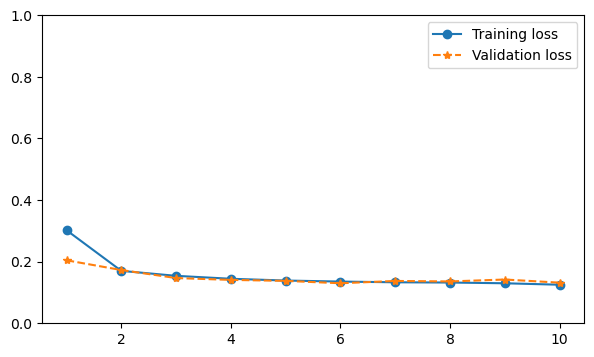

In [31]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
plt.ylim(0, 1)
ax.legend()
plt.show()

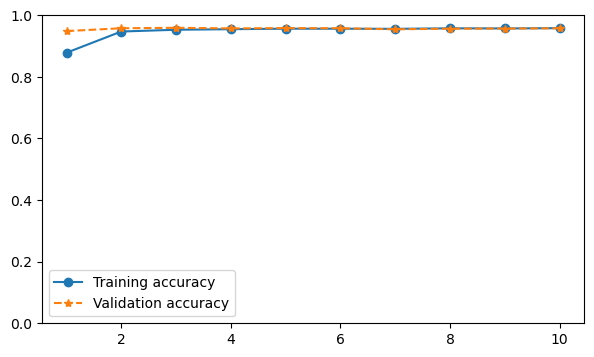

In [32]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
plt.ylim(0, 1)
ax.legend()
plt.show()

In [33]:
model.evaluate(test_data)

130/130 ━━━━━━━━━━━━━━━━━━━━ 99s 762ms/step - accuracy: 0.9550 - loss: 0.1219


[0.1232958734035492, 0.9591392874717712]

130/130 ━━━━━━━━━━━━━━━━━━━━ 94s 716ms/step
Confusion matrix:
 [[1977   91]
 [  78 1990]]


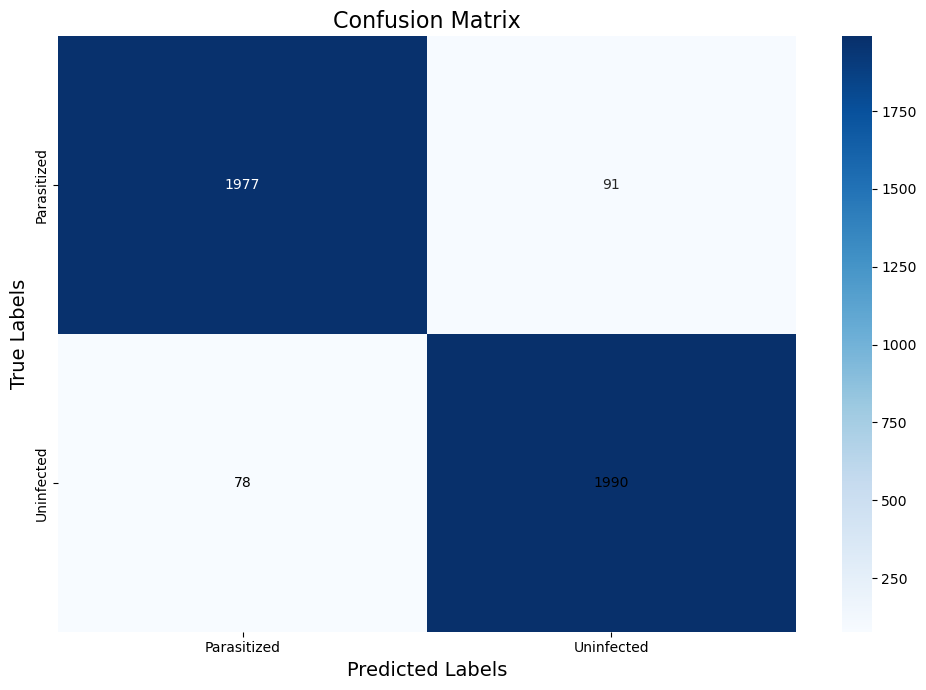

              precision    recall  f1-score   support

 Parasitized       0.96      0.96      0.96      2068
  Uninfected       0.96      0.96      0.96      2068

    accuracy                           0.96      4136
   macro avg       0.96      0.96      0.96      4136
weighted avg       0.96      0.96      0.96      4136



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test data
predictions = model.predict(test_data)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Get true classes
true_classes = test_data.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print("Confusion matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)

for i, value in enumerate(conf_matrix[1]):
    plt.text(i + 0.5, 1.5, str(value), ha="center", va="center", color="black")

plt.xlabel('Predicted Labels', fontsize=14)  # Increase label font size for better visibility
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Ensure tight layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys()))
